### 1. Setup and load data
#### 1.1. Install Dependencies and Setup

In [1]:
import tensorflow as tf
import os

In [2]:
os.listdir()
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

#### 1.2. Remove dodgy images

#### 1.3. Load data

In [3]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dtype=int32)
  tf.Tensor(3, s

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [67]:
data = tf.keras.utils.image_dataset_from_directory('Data', batch_size= 8)

Found 50 files belonging to 2 classes.


In [6]:
data_iterator = data.as_numpy_iterator()

In [7]:
# Get another batch of data
batch = data_iterator.next()

In [8]:
#Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [9]:
# Class 1 = Orders
# Class 0 = Danger
batch[1]

array([1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

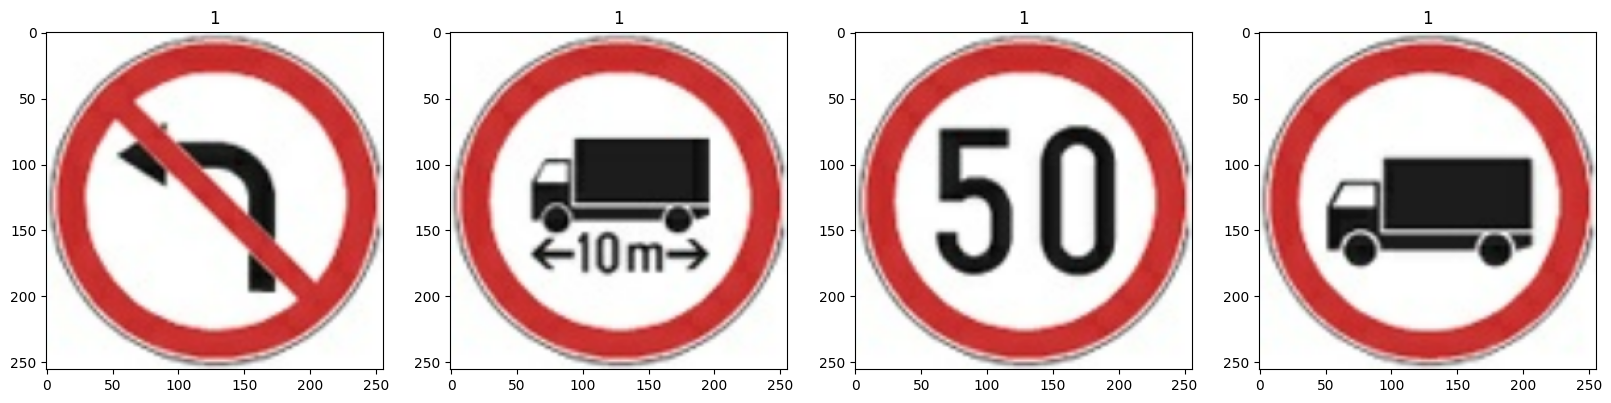

In [11]:
fig, ax = plt.subplots(ncols=4,  figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])
    # ax[idx].set_xticks([])
    # ax[idx].set_yticks([])

In [19]:
scaled = batch[0] / 255


In [22]:
scaled.max()

1.0

### 2. Preproccess Data
#### 2.1.Scale Data

In [68]:
data = data.map(lambda x, y: (x / 255, y))

In [69]:
data.as_numpy_iterator().next()[0].max()
batch = data.as_numpy_iterator().next()

In [70]:
batch[0].max()

1.0

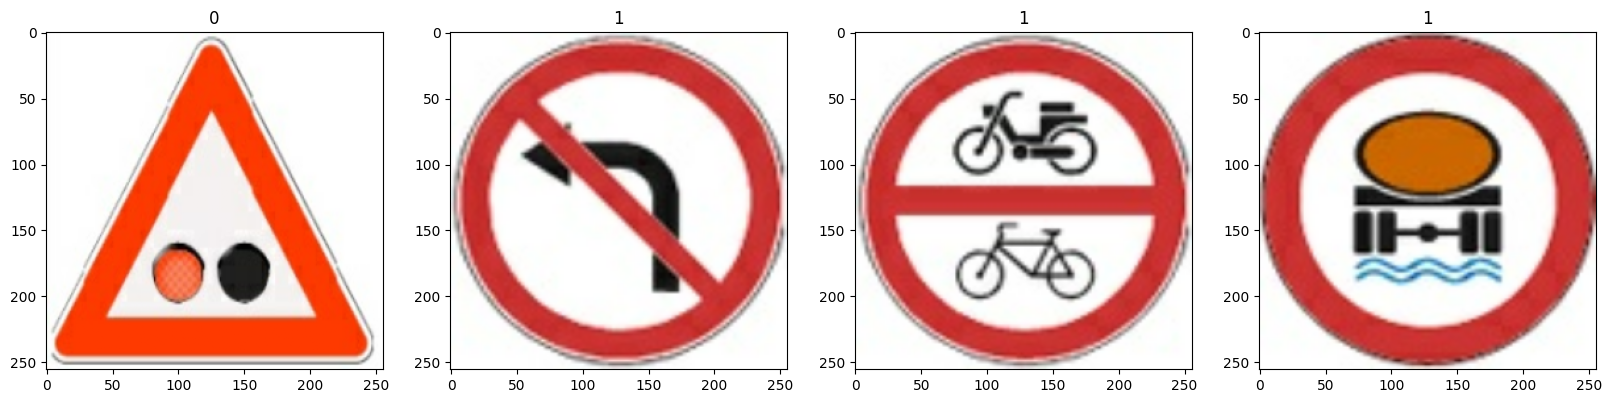

In [71]:
fig, ax = plt.subplots(ncols=4,  figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])
    # ax[idx].set_xticks([])
    # ax[idx].set_yticks([])

#### 2.2. Split Data

In [72]:
len(data)

7

In [79]:
train_size = int(0.7 * len(data))
val_size = int(0.2 * len(data)) + 1
test_size = int(0.1 * len(data)) + 1 

In [84]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [87]:
len(train), len(val), len(test)

(4, 2, 1)

### 3. Deep model
#### 3.1. Build Deep Learning Model

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [93]:
model = Sequential()

In [94]:
MaxPooling2D??

Init signature:
MaxPooling2D(
    pool_size=(2, 2),
    strides=None,
    padding='valid',
    data_format=None,
    **kwargs,
)
Source:        
@keras_export("keras.layers.MaxPool2D", "keras.layers.MaxPooling2D")
class MaxPooling2D(Pooling2D):
    """Max pooling operation for 2D spatial data.

    Downsamples the input along its spatial dimensions (height and width)
    by taking the maximum value over an input window
    (of size defined by `pool_size`) for each channel of the input.
    The window is shifted by `strides` along each dimension.

    The resulting output,
    when using the `"valid"` padding option, has a spatial shape
    (number of rows or columns) of:
    `output_shape = math.floor((input_shape - pool_size) / strides) + 1`
    (when `input_shape >= pool_size`)

    The resulting output shape when using the `"same"` padding option is:
    `output_shape = math.floor((input_shape - 1) / strides) + 1`

    For example, for `strides=(1, 1)` and `padding="valid"`:

    >>

In [100]:
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [101]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [103]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

#### 3.2. Train

In [104]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir)

In [105]:
hist = model.fit(train, validation_data=val, epochs=20, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 1s 232ms/step - loss: 0.6420 - accuracy: 0.6562 - val_loss: 0.1343 - val_accuracy: 1.0000
Epoch 2/20
4/4 [==============================] - 1s 182ms/step - loss: 0.0897 - accuracy: 0.9688 - val_loss: 0.0153 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 1s 170ms/step - loss: 0.0185 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/20
4/4 [==============================] - 1s 172ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.4670e-05 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 1s 178ms/step - loss: 6.6795e-04 - accuracy: 1.0000 - val_loss: 4.0767e-05 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 1s 186ms/step - loss: 4.8056e-05 - accuracy: 1.0000 - val_loss: 3.8164e-05 - val_accuracy: 1.0000
Epoch 7/20
4/4 [==============================] - 1s 180ms/step - loss: 1.7162e-05 - accuracy: 1.0000 - val_loss: 6.2412e-07 - val_accuracy:

In [107]:
hist.history

{'loss': [0.6420259475708008,
  0.08967716991901398,
  0.018451230600476265,
  0.003261934034526348,
  0.0006679525831714272,
  4.805571734323166e-05,
  1.716153565212153e-05,
  5.219479135121219e-06,
  2.3300328393816017e-05,
  3.646564209702774e-06,
  1.3331691661733203e-05,
  8.51560525916284e-06,
  9.89060140454967e-07,
  7.981593626027461e-07,
  2.361530050620786e-06,
  1.4442014162341366e-06,
  1.1190543318662094e-06,
  1.3935572269474505e-06,
  8.605038033238088e-07,
  8.420685162491282e-07],
 'accuracy': [0.65625,
  0.96875,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 'val_loss': [0.13428515195846558,
  0.015269950032234192,
  0.0017095821676775813,
  2.4670329366927035e-05,
  4.0767252357909456e-05,
  3.8164202123880386e-05,
  6.241240839699458e-07,
  3.644213211373426e-05,
  8.680544283379277e-08,
  2.2840402380097657e-05,
  4.8834092325478196e-09,
  2.406198746029986e-06,
  6.993834631430218e

#### 3.3. Plot Performance

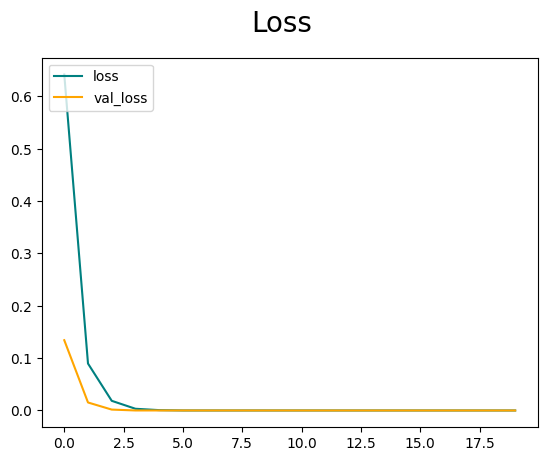

In [109]:
fig = plt.figure()
plt.plot(hist.history['loss'], label='loss', color='teal')
plt.plot(hist.history['val_loss'], label='val_loss', color='orange')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

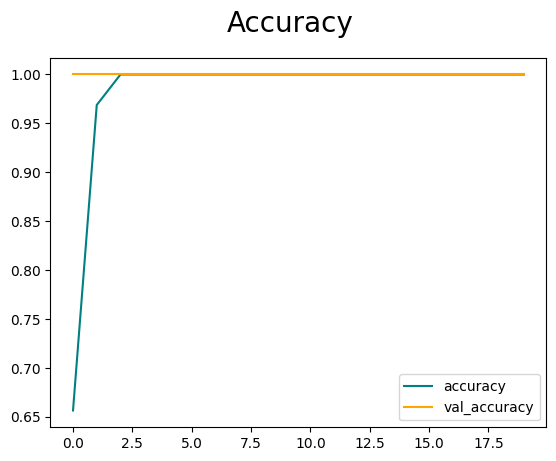

In [112]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], label='accuracy', color='teal')
plt.plot(hist.history['val_accuracy'], label='val_accuracy', color='orange')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='lower right')
plt.show()

### 4. Evaluate performance
#### 4.1. Evaluate

In [113]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [115]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [117]:
for batch in test.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 90ms/step


In [119]:
print(f'Precision: {pre.result().numpy()}')
print(f'Recall: {rec.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 1.0
Recall: 1.0
Accuracy: 1.0


#### 4.2. Test

In [120]:
import cv2

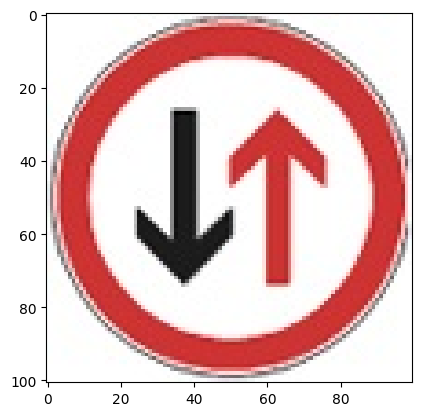

In [128]:
img = cv2.imread('Images/image_2134.jpg')
imgAsRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(imgAsRGB)
plt.show()


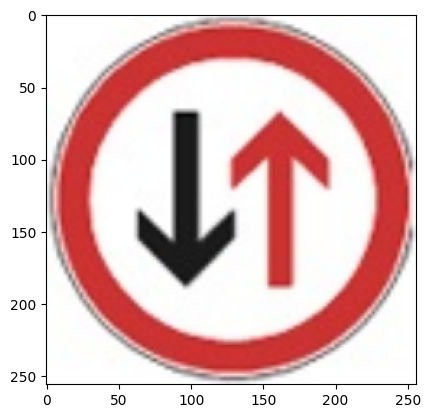

In [130]:
resize = tf.image.resize(imgAsRGB, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [133]:
resize.shape

TensorShape([256, 256, 3])

In [132]:
np.expand_dims(resize, axis=0).shape

(1, 256, 256, 3)

In [134]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 19ms/step


In [137]:
yhat

array([[1.]], dtype=float32)

In [140]:
if yhat > 0.5:
    print(f'Predicted class is {yhat} and is an order')
else:
    print(f'Predicted class is {yhat} and is a danger')

Predicted class is [[1.]] and is an order


### 5. Save the model
#### 5.1. Save the model

In [ ]:
from tensorflow.keras.models import load_model

In [142]:
model.save(os.path.join('models', 'DangerVsOrder.h5'))

In [143]:
new_model = load_model(os.path.join('models', 'DangerVsOrder.h5'))

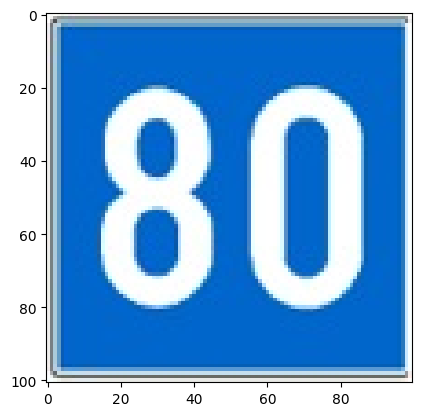

In [169]:
img = cv2.imread('Images/image_2229.jpg')
imgAsRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(imgAsRGB)
plt.show()

In [170]:
resize = tf.image.resize(imgAsRGB, (256, 256))

In [171]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 18ms/step


In [172]:
if yhatnew > 0.5:
    print(f'Predicted class is {yhatnew} and is an order')
else:
    print(f'Predicted class is {yhatnew} and is a danger')

Predicted class is [[0.00229279]] and is a danger
